In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy import linalg as LA
import scipy.optimize as opt


def w2(x):
    return (x**2+1)*norm.cdf(x)+x*norm.pdf(x)
def w1(x):
    return x*norm.cdf(x) + norm.pdf(x)
def w0(x):
    return norm.cdf(x)

def findDelta_zeroGam(sig):
    def findRootOf(delt):
        return w2(delt)-sig**(-2) 
    a = opt.newton(findRootOf,0)
    return a

def fullCav_zeroGam(mu,sig):
    delt = findDelta_zeroGam(sig)
    phi_K = w0(delt)
    m = w1(delt) / (mu*w1(delt) + delt)
    q = ( 1/sig / (mu*w1(delt) + delt) )**2
    return phi_K, m, q, delt 

def lotka_volterra(N, alpha):
    np.dot(alpha, N)  
    dNdt = N * (1 - N) - N * np.dot(alpha, N) 
    return dNdt


def rk4_step(f, N, t, dt, h):
    k1 = f(N, h)
    k2 = f(N + 0.5 * dt * k1, h)
    k3 = f(N + 0.5 * dt * k2, h)
    k4 = f(N + dt * k3, h)
    return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


def solve_lotka_volterra(alpha, N0, t_max, dt):
    t_values = np.arange(0, t_max, dt)
    N_values = np.zeros((len(t_values), len(N0)))
    N_values[0] = N0
    for i in range(1, len(t_values)):
        N_values[i] = rk4_step(lotka_volterra, N_values[i-1], t_values[i-1], dt, alpha)
    return t_values, N_values

def alphagen(mu,sigma, S):
    Alpha = np.random.normal(mu/S, sigma/np.sqrt(S), size=(S, S))
    np.fill_diagonal(Alpha, 0)
    return Alpha

def alphagen_withGamma(mu,sigma,gamma,S):
    Alpha = np.zeros((S,S))
    variance = (sigma**2)/S 
    mean = mu/S 
    cov_ab = (gamma * sigma**2) / S
    covariance_matrix = [[variance, cov_ab],
                         [cov_ab, variance]]
    means = [mean, mean]
    for i in range(S):
        for j in range(i + 1, S):
            ab_values = np.random.multivariate_normal(means, covariance_matrix,1)
            a = ab_values[:,0]
            b = ab_values[:,1]
            Alpha[i,j] = a[0]
            Alpha[j,i] = b[0]
    return Alpha
    
def get_Ms(N_values, t_values):
    Ms = []
    length = len(t_values)
    for i in range(length):
        A = sum(N_values[i])/S
        Ms.append(A)
    return Ms

def Corrolator(diff, N_values, t_values):
    Cs = []
    length = len(t_values)
    for i in range(diff, length):
        A = sum(N_values[i]*N_values[i-diff])/S
        Cs.append(A)
    return Cs

def Mixture_matrix(S,mu,sigma,c):
    G = nx.erdos_renyi_graph(S, c/S)
    adj_matrix = nx.to_numpy_array(G)
    alpha = np.random.normal(mu/c , sigma/(np.sqrt(c)),size=(S,S))
    interaction_matirx = adj_matrix * alpha
    np.fill_diagonal(interaction_matirx, 0)
    return interaction_matirx

def findDelta_withGam(sig, gam):
    def findRootOf(x):
        # I went to log space in order to have better numerical convergence. Gam=-1 seems problematic.
        correctedGam = np.maximum(gam, -1+1e-8)
        return 2*np.log(sig) + 2*np.log( np.abs( 1 + correctedGam * w0(x)/w2(x) ) ) + np.log( w2(x) )
    return opt.newton(findRootOf,0)
    
def fullCav_withGam(mu,sig,gam):
    delt = findDelta_withGam(sig, gam)
    m = w1(delt)/(  delt*sig**2*( w2(delt)+gam*w0(delt) ) + mu*w1(delt)  )
    q = ( sig*( w2(delt)+gam*w0(delt) ) / ( delt*sig**2*(w2(delt)+gam*w0(delt)) + mu*w1(delt) ) )**2
    if gam==0:
        K = w0(delt)
    else:
        K = (1/sig**2 - w2(delt) )/gam - w0(delt)
    phi = w0(delt)
    return (phi, K, m, q, delt)

def findEpsilon(mu,sig,S):
    delt = findDelta_zeroGam(sig)
    M = w1(delt) / (mu*w1(delt) + delt)
    q = ( 1/sig / (mu*w1(delt) + delt) )**2
    mean = 1-mu*M
    varience = (sig**2)*q
    def findRootOf(e):
        return norm.cdf(e,mean,np.sqrt(varience)) - norm.cdf(0,mean,np.sqrt(varience)) - 1/S
    a = opt.newton(findRootOf,0)
    return a

def findEpsilon_withgamma(gam,mu,sig,S):
    delt = findDelta_withGam(sig, gam)
    M = w1(delt)/(  delt*sig**2*( w2(delt)+gam*w0(delt) ) + mu*w1(delt)  )
    q = ( sig*( w2(delt)+gam*w0(delt) ) / ( delt*sig**2*(w2(delt)+gam*w0(delt)) + mu*w1(delt) ) )**2
    if gam==0:
        K = w0(delt)
    else:
        K = (1/sig**2 - w2(delt) )/gam - w0(delt)
    den = 1-gam*(sig**2)*K
    mean = (1-mu*M)/den
    varience = ((sig**2)*q)/(den**2)
    def findRootOf(e):
        return norm.cdf(e,mean,np.sqrt(varience)) - norm.cdf(0,mean,np.sqrt(varience)) - 1/S
    a = opt.newton(findRootOf,0)
    return a
    
    

In [30]:
S = 250
mu = 4
sigma = 1.1
t_max = 2000
dt = 0.05
gamma = 1
start0 = np.random.uniform(0, 1, size=S)

### Visualisng dynamics

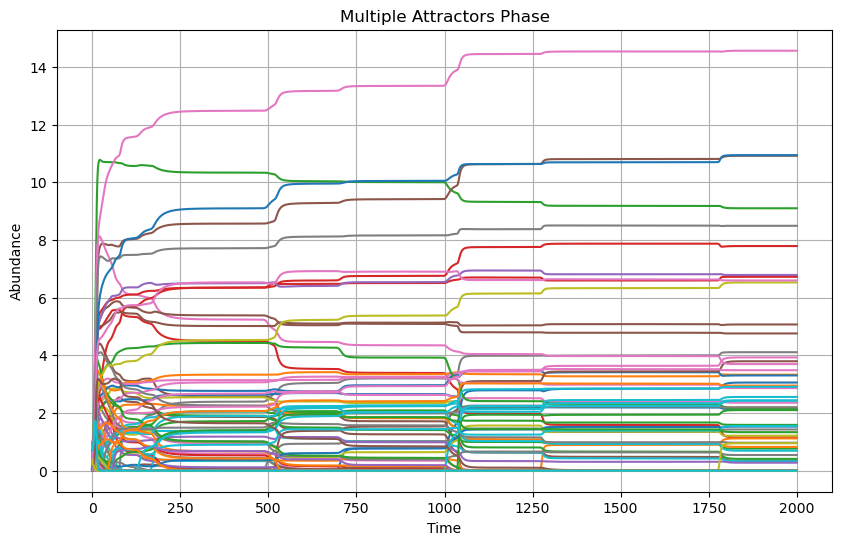

In [33]:
alpha = alphagen_withGamma(mu,sigma,gamma,S)
ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)


plt.figure(figsize=(10, 6))
for i in range(S):
    plt.plot(ts0, Ns0[:, i])
plt.xlabel('Time')
plt.ylabel('Abundance')
plt.title('Multiple Attractors Phase')
plt.grid(True)
plt.show()

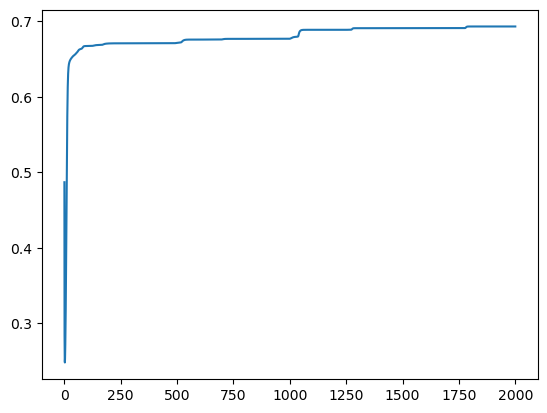

In [39]:
Ms = get_Ms(Ns0, ts0)
plt.plot(ts0,Ms)

### Plots for Phi depended behavours for fixed C

#### Plots for fully connected normal 

/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_3524/3762143870.py:32: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * np.dot(alpha, N)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_3524/3762143870.py:32: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * np.dot(alpha, N)


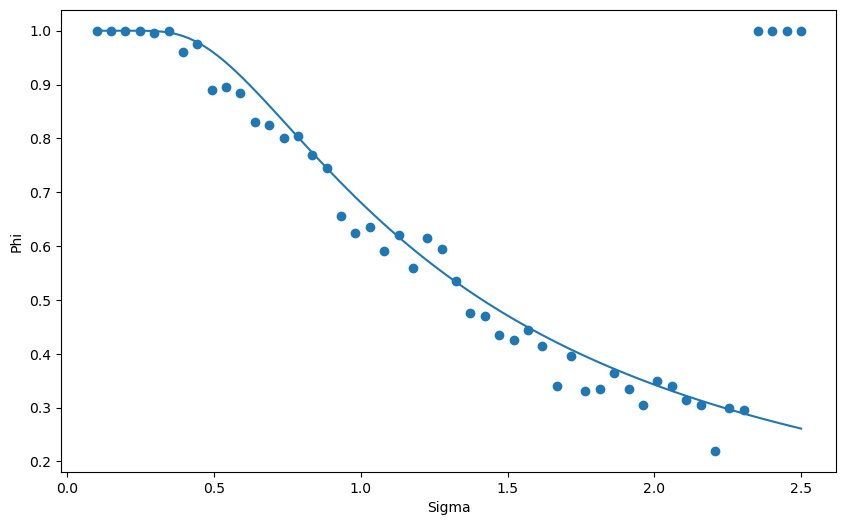

In [104]:
S = 200
mu = 4
t_max = 500
dt = 0.05
c = 10
start0 = np.random.uniform(0, 1, size=S)

TheoryPhis = []
TheorySigs = np.linspace(0.1,2.5,100)
for i in TheorySigs:
    phi = fullCav_zeroGam(mu,i)[0]
    TheoryPhis.append(phi)

Sigs = np.linspace(0.1,2.5,50)


fracdead = []

for i, sig in enumerate(Sigs): 
    epsilon = findEpsilon(mu,sigma,S)
    dead = 0
    alpha = alphagen(mu,sig, S)
    ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)
    for j in Ns0[-1]:
        if j < epsilon:
            dead = dead +1
    fracdead.append(1 - dead/S)


    
plt.figure(figsize=(10, 6))
plt.plot(TheorySigs, TheoryPhis) 
plt.scatter(Sigs, fracdead) 
plt.xlabel('Sigma')
plt.ylabel(r'Phi')
plt.show()

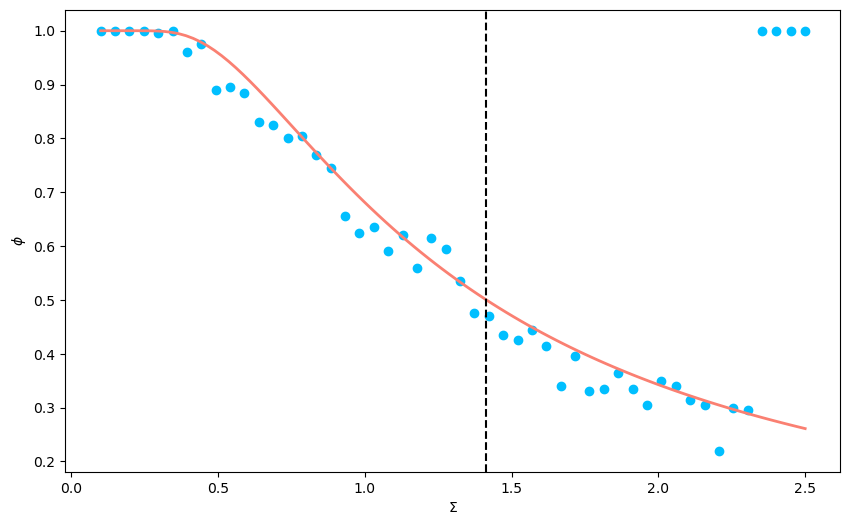

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(TheorySigs, TheoryPhis, color='salmon',linewidth = 2) 
plt.scatter(Sigs, fracdead, color='deepskyblue') 
plt.axvline(x = np.sqrt(2), color='black',linestyle = '--')
plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$\phi$')
plt.show()

#### Plots for phi over differnt C

/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_8331/3762143870.py:32: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * np.dot(alpha, N)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_8331/3762143870.py:32: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * np.dot(alpha, N)


Done for C = 6
Done for C = 20


/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_8331/3762143870.py:41: RuntimeWarning: overflow encountered in multiply
  return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


Done for C = 50
Done for C = 100
Done for C = 150
Done for C = 200


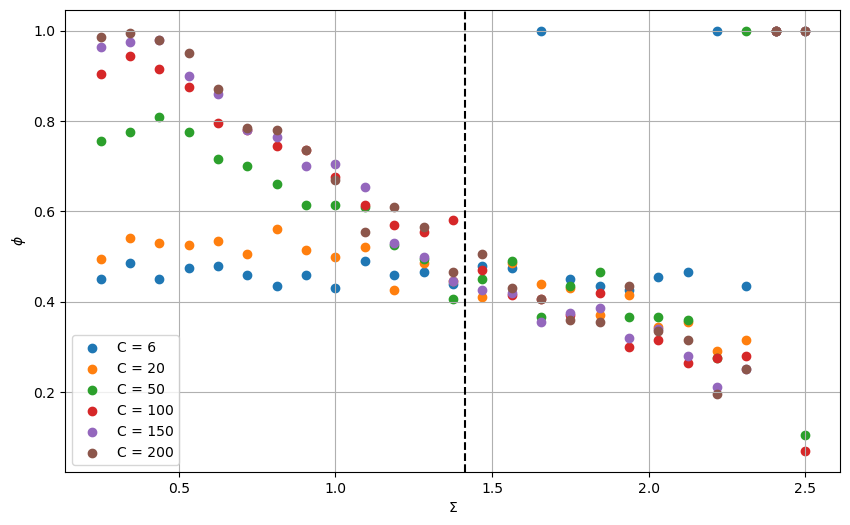

In [23]:
S = 200
mu = 4
t_max = 2000
dt = 0.05
Cs = [6,20, 50, 100, 150, 200]
start0 = np.random.uniform(0, 1, size=S)




plt.figure(figsize=(10, 6))

for c in Cs:
    Sigs = np.linspace(0.25,2.5,25)
    fracdead_all_sigs = []
    for i, sig in enumerate(Sigs): 
        fracdead = []
        epsilon = findEpsilon(mu,sig,S)
        dead = 0
        alpha = Mixture_matrix(S,mu,sig,c)
        ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)
        for j in Ns0[-1]:
            if j < epsilon:
                dead = dead +1
        fracdead.append(1 - dead/S)
        fracdead_all_sigs.append(fracdead[0])
    plt.scatter(Sigs, fracdead_all_sigs, label = f"C = {c}")
    print(f"Done for C = {c}") 

plt.axvline(x = np.sqrt(2), color='black',linestyle = '--')
plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.grid()
plt.show()

#### Plots for Phi in Fully Connected but with different Gamma

Done Theory line for gamma = -1
Done for Gamma = -1
Done Theory line for gamma = -0.5
Done for Gamma = -0.5
Done Theory line for gamma = 0


/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_6362/1145687456.py:32: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * np.dot(alpha, N)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_6362/1145687456.py:32: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * np.dot(alpha, N)


Done for Gamma = 0
Done Theory line for gamma = 0.5
Done for Gamma = 0.5
Done Theory line for gamma = 1


/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_6362/1145687456.py:41: RuntimeWarning: overflow encountered in multiply
  return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


Done for Gamma = 1


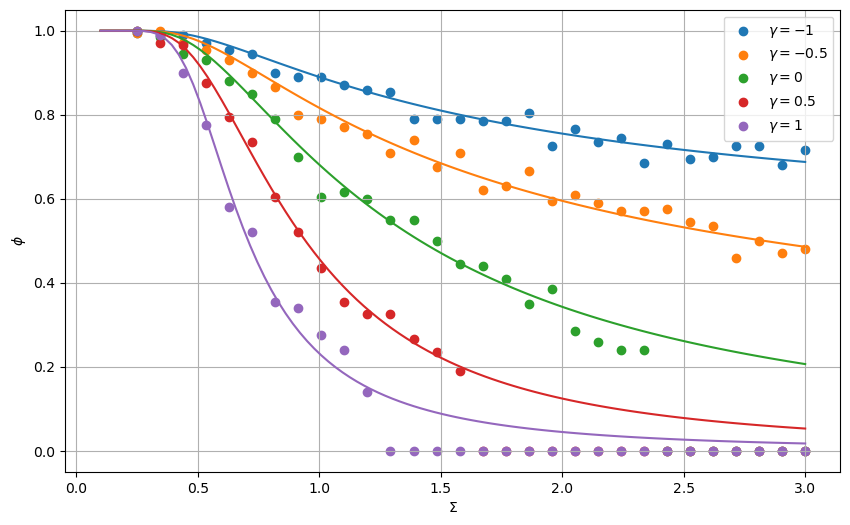

In [19]:
S = 200
mu = 4
t_max = 1000
dt = 0.05
Gammas = [-1, -0.5, 0, 0.5, 1]
start0 = np.random.uniform(0, 1, size=S)

plt.figure(figsize=(10, 6))







for gamma in Gammas:
    ## For Theory Lines
    TheoryPhis = []
    TheorySigs = np.linspace(0.1,3,100)
    for i in TheorySigs:
        delt = findDelta_withGam(i, gamma)
        phi = w0(delt)
        TheoryPhis.append(phi)
    ## For Calculated Lines
    Sigs = np.linspace(0.25,3,30)
    fracdead = []
    print(f"Done Theory line for gamma = {gamma}")
    for i, sig in enumerate(Sigs): 
        epsilon = findEpsilon_withgamma(gamma,mu,sig,S)
        dead = 0
        alpha = alphagen_withGamma(mu,sig,gamma,S)
        ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)
        if np.any(np.isnan(Ns0[-1])):
                  fracdead.append(0)
        else:
            for j in Ns0[-1]:
                if j < epsilon:
                    dead = dead +1
            fracdead.append(1 - dead/S)
    plt.scatter(Sigs, fracdead, label=rf"$\gamma = {gamma}$")
    plt.plot(TheorySigs, TheoryPhis)
    print(f"Done for Gamma = {gamma}") 

plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.grid()
plt.show()

### Plots for M(t) for different sigma in sparce and FC

done 1 of 40
done 2 of 40
done 3 of 40
done 4 of 40
done 5 of 40
done 6 of 40
done 7 of 40
done 8 of 40
done 9 of 40
done 10 of 40
done 11 of 40
done 12 of 40
done 13 of 40
done 14 of 40
done 15 of 40
done 16 of 40
done 17 of 40
done 18 of 40
done 19 of 40


/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_3524/2841308096.py:34: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * np.dot(alpha, N)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_3524/2841308096.py:34: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * np.dot(alpha, N)
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_3524/2841308096.py:43: RuntimeWarning: overflow encountered in multiply
  return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


done 20 of 40
done 21 of 40
done 22 of 40
done 23 of 40
done 24 of 40
done 25 of 40
done 26 of 40
done 27 of 40
done 28 of 40
done 29 of 40
done 30 of 40


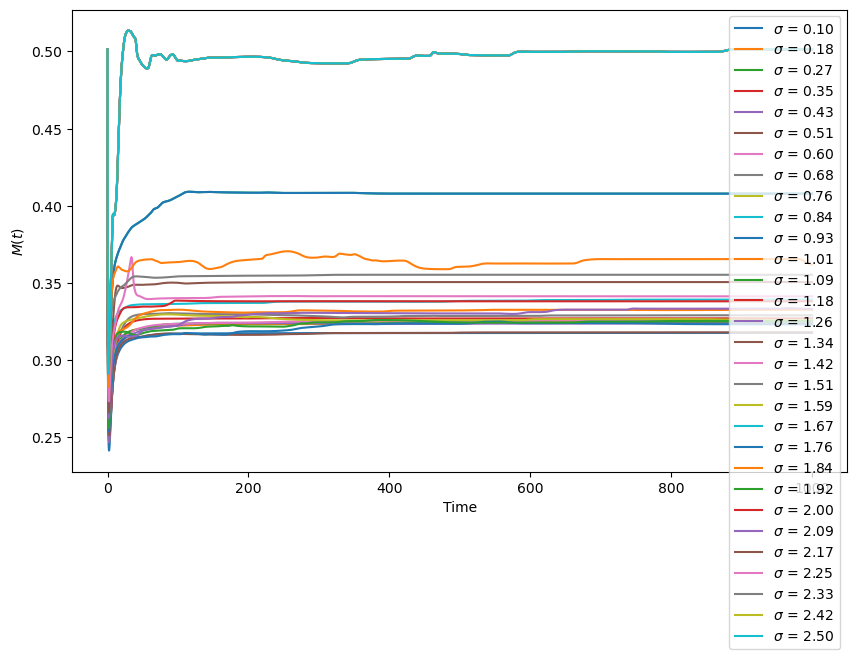

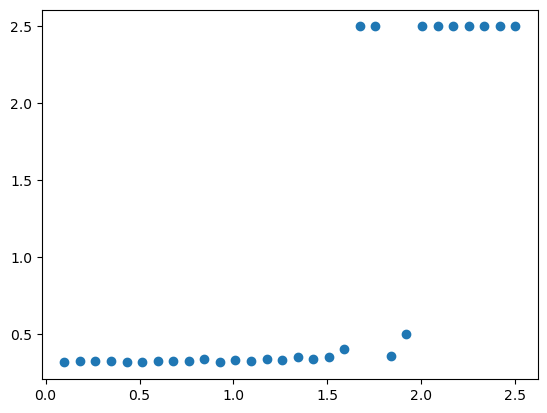

In [53]:
sigs = np.linspace(0.1,2.5,30)
lastms = []
plt.figure(figsize=(10, 6))
count = 0
for i, sig in enumerate(sigs): #Enumerate to get the correct index
    alpha = Mixture_matrix(S, mu, sig, c)
    ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)
    if np.any(np.isnan(Ns0)):
        lastms.append(2.5)
    else:
        M = get_Ms(Ns0, ts0)
        lastms.append(M[-1])
    plt.plot(ts0, M, label=r"$\sigma$ = {:.2f}".format(sig)) #Format the label
    print("done", i+1, "of 40" )
    

plt.xlabel('Time')
plt.ylabel(r'$M(t)$')
plt.legend()
plt.show()

plt.scatter(sigs, lastms)
plt.show()

done 1 of 20
done 2 of 20
done 3 of 20
done 4 of 20
done 5 of 20
done 6 of 20
done 7 of 20
done 8 of 20
done 9 of 20
done 10 of 20
done 11 of 20
done 12 of 20
done 13 of 20
done 14 of 20
done 15 of 20
done 16 of 20
done 17 of 20
done 18 of 20
done 19 of 20
done 20 of 20


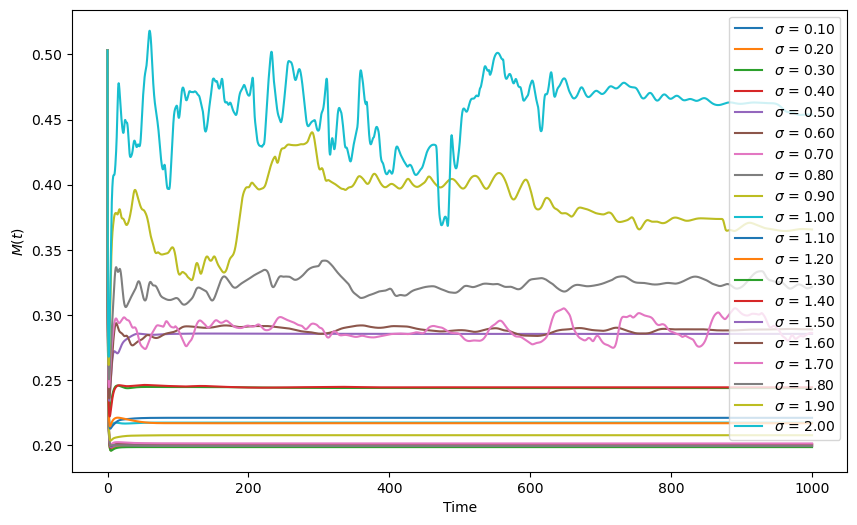

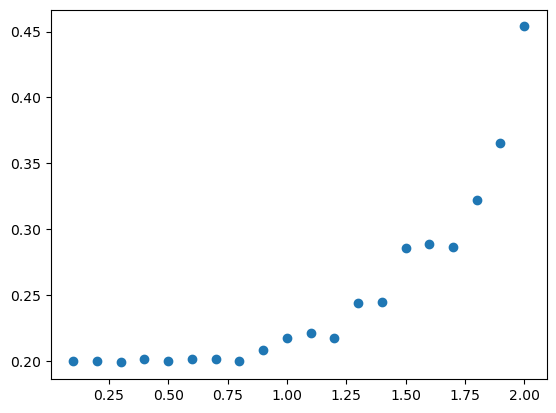

In [37]:
sigs2 = np.linspace(0.1,2,20)
lastms2 = []
plt.figure(figsize=(10, 6))
for i, sig in enumerate(sigs2): #Enumerate to get the correct index
    alpha = alphagen(mu,sig, S)
    ts0, Ns0 = solve_lotka_volterra(alpha, start0, t_max, dt)
    if np.any(np.isnan(Ns0)):
        lastms.append(5)
    else:
        M = get_Ms(Ns0, ts0)
        lastms.append(M[-1])
    plt.plot(ts0, M, label=r"$\sigma$ = {:.2f}".format(sig)) #Format the label
    print("done", i+1, "of 20" )
    

plt.xlabel('Time')
plt.ylabel(r'$M(t)$')
plt.legend()
plt.show()

plt.scatter(sigs2, lastms2)
plt.show()

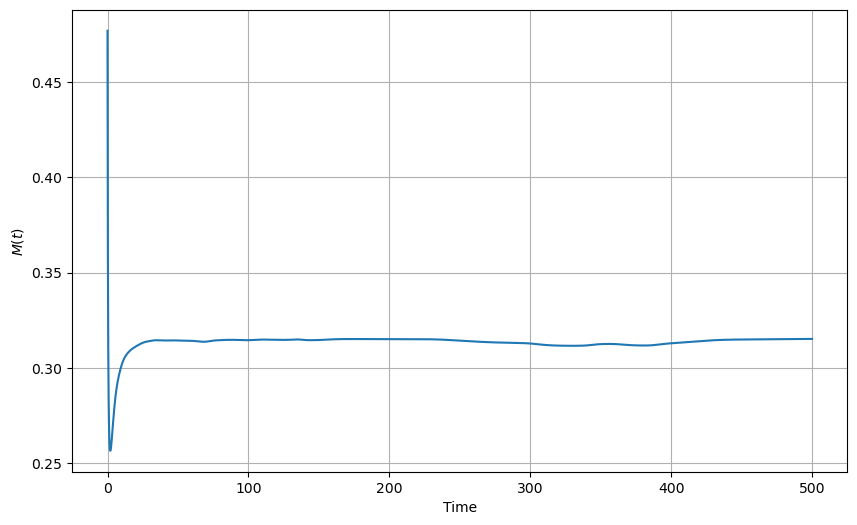

In [11]:
M = get_Ms(Ns0, ts0)


plt.figure(figsize=(10, 6))
plt.plot(ts0, M)
plt.xlabel('Time')
plt.ylabel(r'$M(t)$')
plt.grid(True)
plt.show()

### Plots for C(t,t')

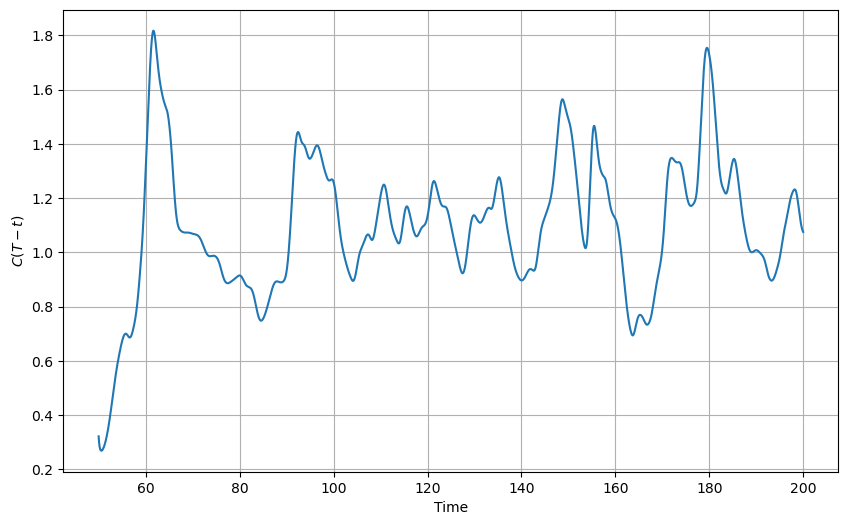

In [293]:
diff = 1000
Cs = Corrolator(diff, Ns0, ts0)

plt.figure(figsize=(10, 6))
plt.plot(ts0[diff:], Cs)
plt.xlabel('Time')
plt.ylabel(r'$C(T-t)$')
plt.grid(True)
plt.show()



/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_18803/3780442936.py:28: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim(Z.min(), Z.min())


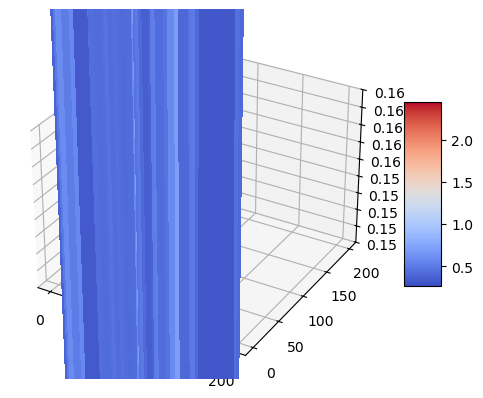

In [295]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

length = len(ts0)
Z = np.zeros((length,length))




# Make data.
X = ts0
Y = ts0
X, Y = np.meshgrid(X, Y)

for i in range(length):
    for j in range(length):
            B = sum(Ns0[i]*Ns0[j])/S
            Z[i,j] = B

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(Z.min(), Z.min())
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

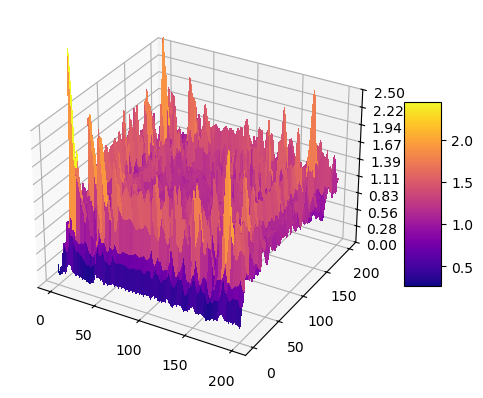

In [308]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X, Y, Z, cmap='plasma',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 2.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Plots for FC spcies abundance distribution and DMFT Phase Diagram

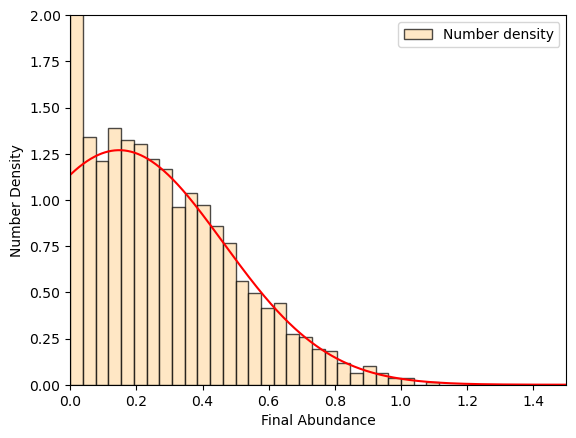

In [57]:
Vals = fullCav_zeroGam(mu,sigma)


mean = sigma -(mu*Vals[1])
varience = (sigma**2)*Vals[2]
stabby = np.sqrt(varience)
x = np.linspace(0, 2, 1000)


final_abundances = N1s[-1] 
bin_edges = np.linspace(0, 1.5, 40)
hist, edges = np.histogram(final_abundances, bins=bin_edges) 
bin_width = edges[1] - edges[0]
number_density = hist / (len(final_abundances) * bin_width)
plt.bar(edges[:-1], number_density, width=bin_width, align='edge', alpha=0.7, edgecolor='black' ,color='navajowhite', label='Number density')
plt.plot(x, norm.pdf(x, mean, stabby),color='r')
plt.ylim(0,2)
plt.xlim(0,1.5)
plt.xlabel("Final Abundance")
plt.ylabel("Number Density")
plt.legend()
plt.show()

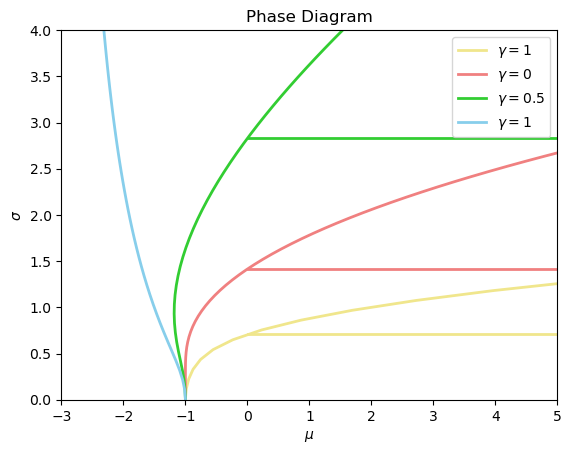

In [75]:
def UG_lines(gamma,sig0,sigmax, delt):
    sigs = np.linspace(sig0,sigmax,delt)
    deltas = []
    for i in sigs:
        delt = findDelta_withGam(i, gamma)
        deltas.append(delt)
        xs = []
        ys = []
        for j in deltas:
            x = -(j*w2(j))/(w1(j)*(w2(j) + gamma*w0(j)))
            y = (np.sqrt(w2(j)))/(w2(j) + gamma*w0(j))
            xs.append(x)
            ys.append(y)   
    return xs, ys
xs1 , ys1 = UG_lines(1,0.01,1.5,15)
xs0 , ys0 = UG_lines(0,0.01,2.75,50)
xsneg05 , ysneg05 = UG_lines(-0.5,0.01,4,40)
xsneg1 , ysneg1 = UG_lines(-1,0.01,4,40)
minny = 0.3755
plt.plot(xs1, ys1, color='khaki', label=r'$\gamma = 1$', linewidth = 2)
plt.plot(xs0, ys0, color='lightcoral', label=r'$\gamma = 0$', linewidth = 2)
plt.plot(xsneg05, ysneg05, color='limegreen', label=r'$\gamma = 0.5$', linewidth = 2)
plt.plot(xsneg1, ysneg1, color='skyblue', label=r'$\gamma = 1$', linewidth = 2)
plt.axhline(y=0.5*np.sqrt(2), xmin=minny, color='khaki', linewidth = 2)
plt.axhline(y=np.sqrt(2), xmin=minny, color='lightcoral', linewidth = 2)
plt.axhline(y=2*np.sqrt(2), xmin=minny, color='limegreen', linewidth = 2)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title('Phase Diagram')  
plt.legend() 
plt.xlim(-3, 5)  
plt.ylim(0, 4)  
plt.show()

In [ ]:
sigma_value_for_mu_4 = 2.49031715164280

siggy = np.linspace(2.490317151642784,2.4903171516428144,1000)
for i in siggy:
    delt = findDelta_zeroGam(i)
    x = -1*(delt/w1(delt))
    if abs(x - 4) < 0.00000000000001:
        print("mu = ", x,"for simga = ",i)

Gamma =  -0.99
141.4213562373094


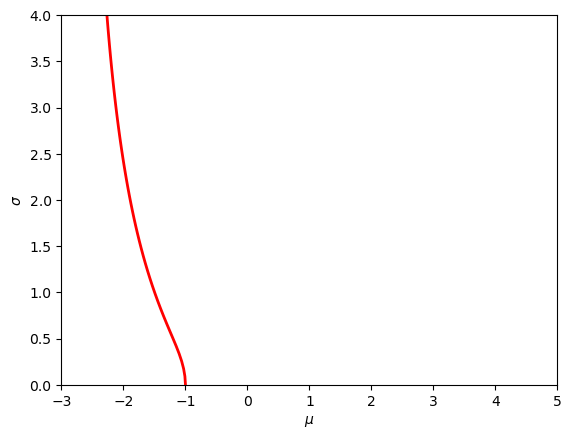

Gamma =  -0.8852631578947369
12.32571453444441


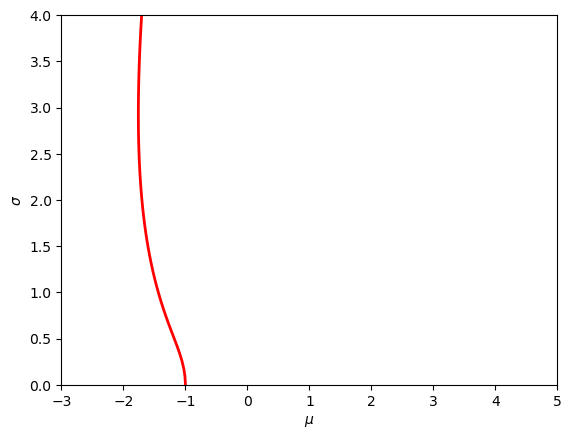

Gamma =  -0.7805263157894737
6.443658917287485


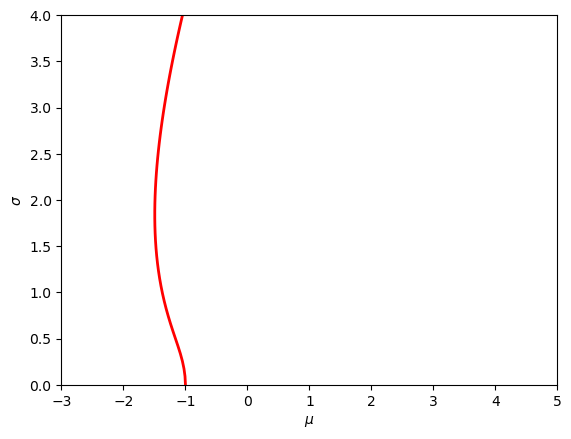

Gamma =  -0.6757894736842105
4.3620223514754555


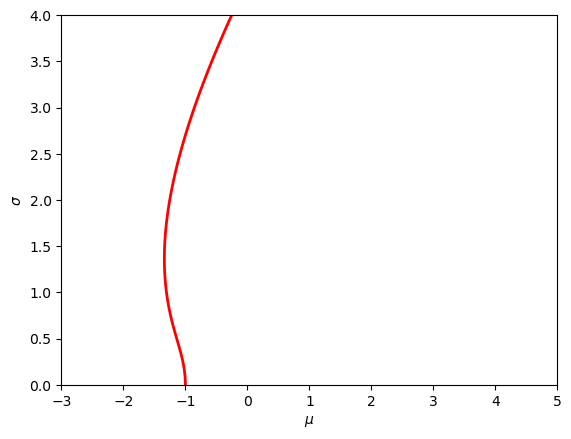

Gamma =  -0.5710526315789474
3.2969395932624304


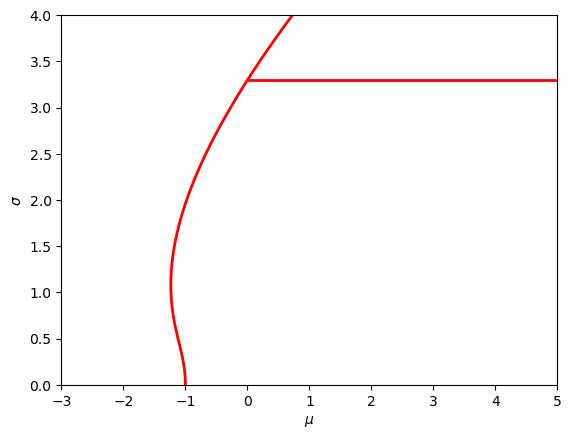

Gamma =  -0.46631578947368424
2.6499070695353857


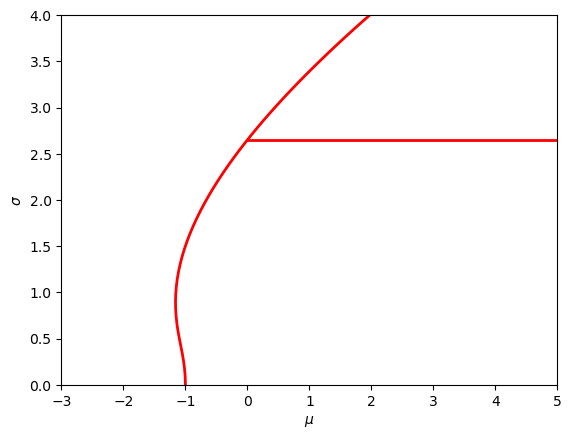

Gamma =  -0.361578947368421
2.2151737580452435


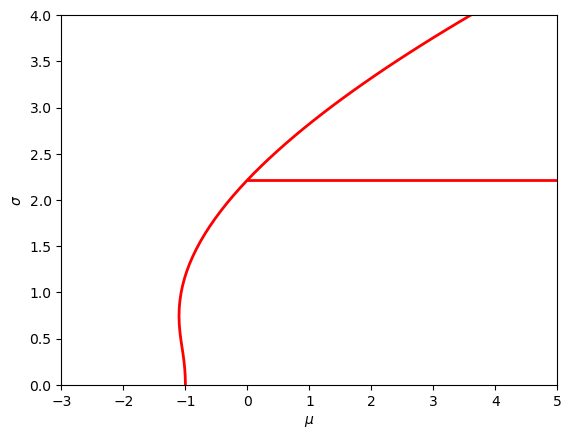

Gamma =  -0.25684210526315787
1.9029785895955245


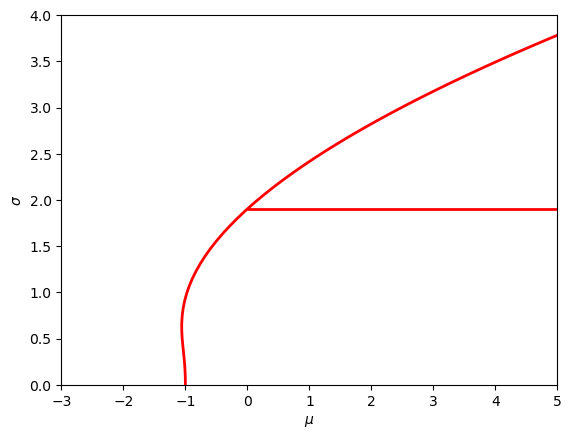

Gamma =  -0.15210526315789474
1.6679117122960154


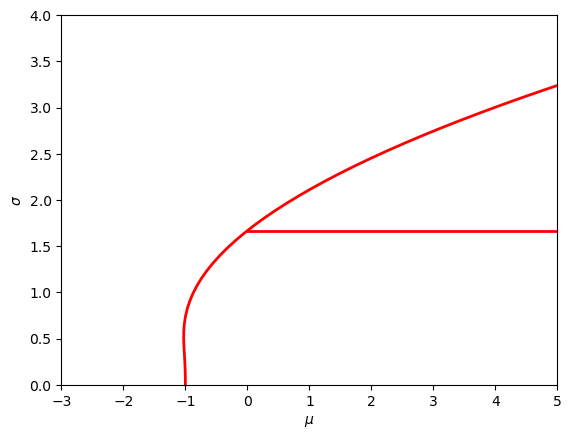

Gamma =  -0.047368421052631615
1.4845335737618126


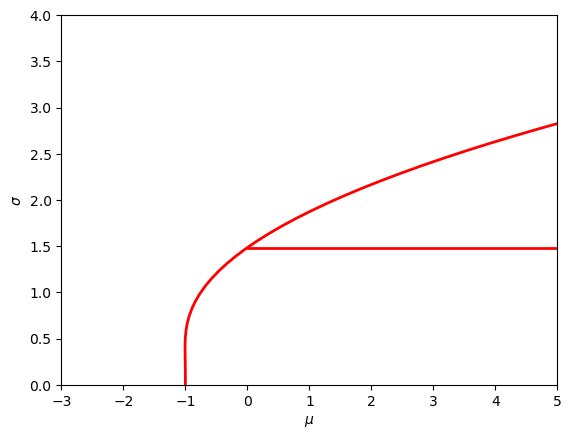

Gamma =  0.05736842105263151
1.3374842053304534


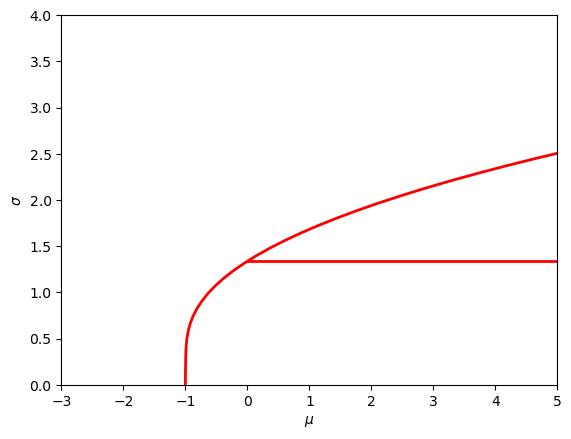

Gamma =  0.16210526315789475
1.2169410183464133


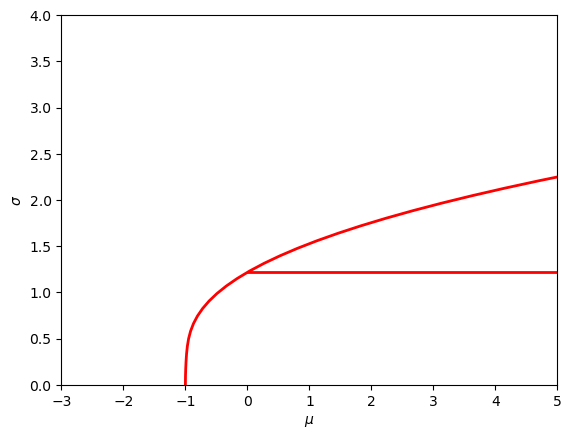

Gamma =  0.266842105263158
1.1163297750348486


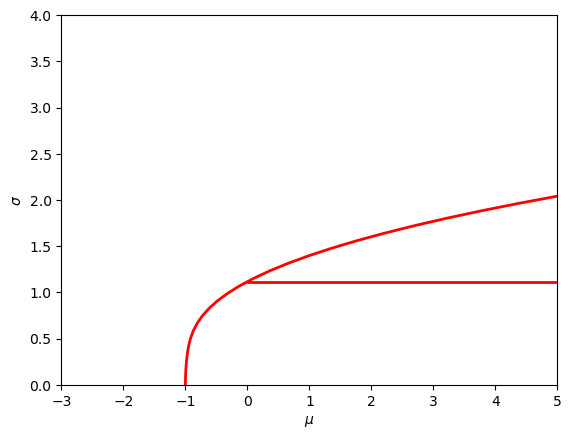

Gamma =  0.371578947368421
1.0310843317378668


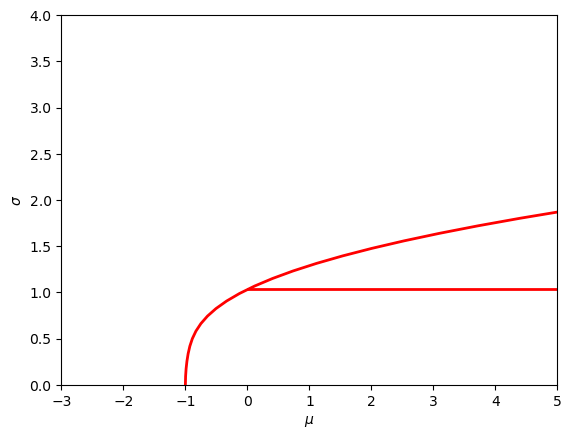

Gamma =  0.47631578947368425
0.9579343203240216


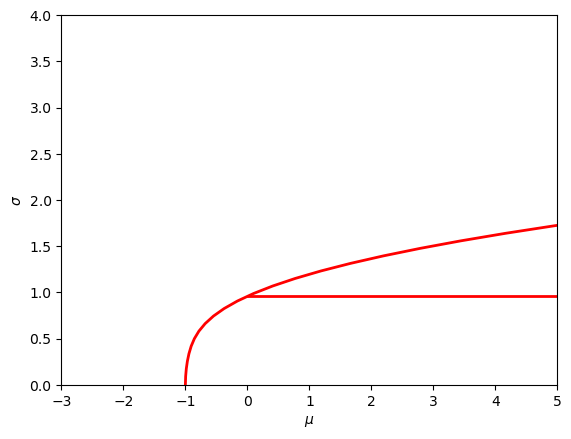

Gamma =  0.5810526315789473
0.8944759548964317


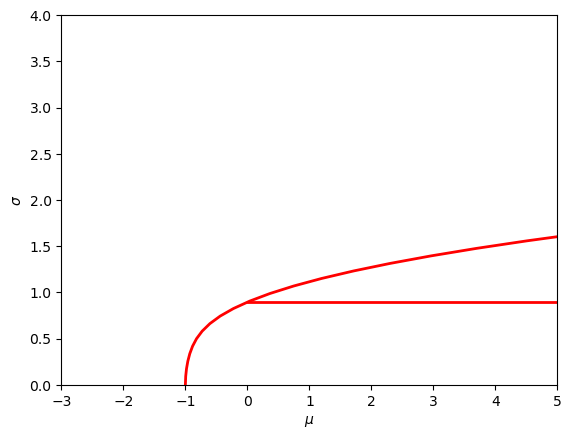

Gamma =  0.6857894736842105
0.838902831254724


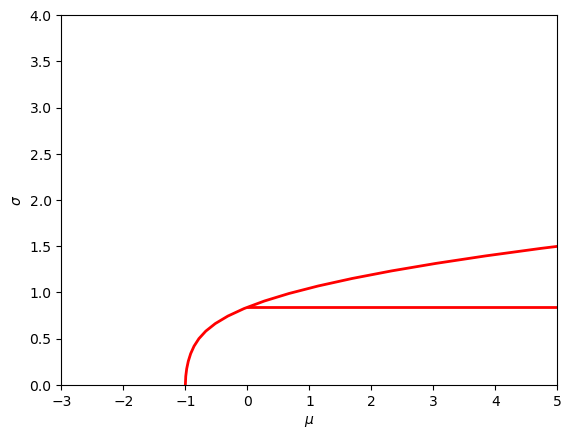

Gamma =  0.7905263157894737
0.7898312076745682


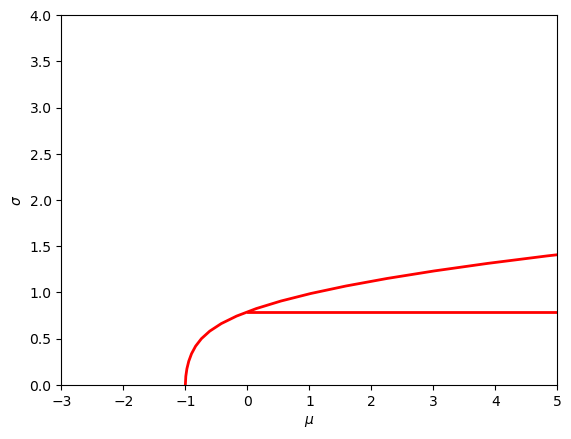

Gamma =  0.8952631578947368
0.7461832181363179


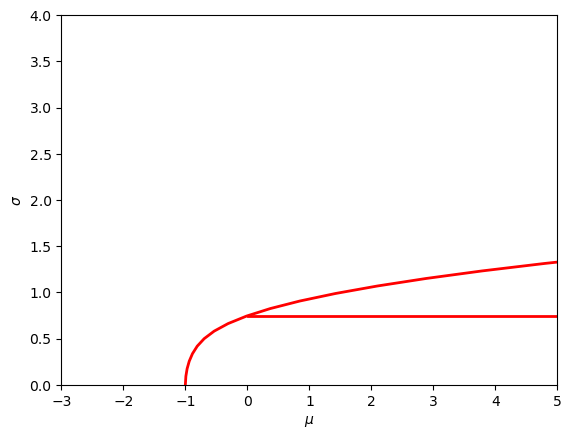

Gamma =  1.0
0.7071067811865476


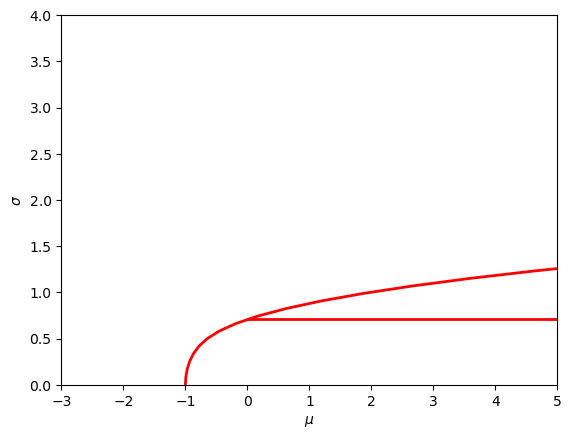

In [89]:
ggs = np.linspace(-0.99,1,20)

for i in ggs:
    print("Gamma = ", i )
    xs1 , ys1 = UG_lines(i,0.01,4,50)
    plt.plot(xs1, ys1, color='red', linewidth = 2)
    plt.axhline(y=np.sqrt(2)/(1+i), xmin=minny, color='red', linewidth = 2)
    print(np.sqrt(2)/(1+i))
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\sigma$') 
    plt.xlim(-3, 5)  
    plt.ylim(0, 4)  
    plt.show()